In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import Dropout, Dense, Flatten, Activation
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.applications.efficientnet_v2 import EfficientNetV2M
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/befork.zip'

Archive:  /content/drive/MyDrive/befork.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: test/
   creating: test/beef/
 extracting: test/beef/FRESH-10-_JPG_jpg.rf.9b20f06d4a6329ea5f7fb60717d4009b.jpg  
 extracting: test/beef/FRESH-108-_JPG_jpg.rf.6db1ac6dc4b1f92c0a3947178bd354c8.jpg  
 extracting: test/beef/FRESH-136-_JPG_jpg.rf.05bd420c7ffc8360353ccf301751d824.jpg  
 extracting: test/beef/FRESH-152-_JPG_jpg.rf.e15fd0b4750fc53bdd4e61b0baec53ee.jpg  
 extracting: test/beef/FRESH-204-_JPG_jpg.rf.9b80b0731ad35e8d6ca759aa35858133.jpg  
 extracting: test/beef/FRESH-21-_JPG_jpg.rf.c09e9df7fd2f7519e5d8ace0425f61a3.jpg  
 extracting: test/beef/FRESH-224-_JPG_jpg.rf.4c82ec6736079a90ad8de8f75ed2f6ca.jpg  
 extracting: test/beef/FRESH-234-_JPG_jpg.rf.dbc736ea03f94120f5255fdb2f2e2113.jpg  
 extracting: test/beef/FRESH-242-_JPG_jpg.rf.bf8ebfe5fbfe18395f1eb693dc845f93.jpg  
 extracting: test/beef/FRESH-260-_JPG_jpg.rf.1d3b8e6c5678bff7d70314fa453b64d2.jpg  

In [ ]:
base_dir = '/content/'

In [ ]:
#Eksplor the dataset
import os
for dirpath, dirnames, filenames in os.walk(base_dir):
  print(f'Ada {len(dirnames)} directori dan {len(filenames)} gambar dalam {dirpath}')

Ada 6 directori dan 2 gambar dalam /content/
Ada 2 directori dan 6 gambar dalam /content/.config
Ada 1 directori dan 0 gambar dalam /content/.config/logs
Ada 0 directori dan 6 gambar dalam /content/.config/logs/2023.06.05
Ada 0 directori dan 1 gambar dalam /content/.config/configurations
Ada 2 directori dan 0 gambar dalam /content/test
Ada 0 directori dan 57 gambar dalam /content/test/beef
Ada 0 directori dan 61 gambar dalam /content/test/pork
Ada 2 directori dan 0 gambar dalam /content/train
Ada 0 directori dan 1356 gambar dalam /content/train/beef
Ada 0 directori dan 1104 gambar dalam /content/train/pork
Ada 4 directori dan 0 gambar dalam /content/drive
Ada 35 directori dan 607 gambar dalam /content/drive/MyDrive
Ada 11 directori dan 0 gambar dalam /content/drive/MyDrive/Classroom
Ada 0 directori dan 0 gambar dalam /content/drive/MyDrive/Classroom/UKBM 20
Ada 0 directori dan 1 gambar dalam /content/drive/MyDrive/Classroom/UKBM 25 Expressing Contrast
Ada 0 directori dan 1 gambar dalam

In [ ]:
#define batch size and set size of images
batch_size = 32
image_size = (224, 224)

#path of dataset
train_dir = os.path.join(base_dir +'/train')
valid_dir = os.path.join(base_dir +'/valid')
test_dir = os.path.join(base_dir +'/test')

#image generator
train_dataset = tf.keras.utils.image_dataset_from_directory('/content/train',
                                                            shuffle=True,
                                                            batch_size=batch_size,
                                                            image_size=image_size)

valid_dataset = tf.keras.utils.image_dataset_from_directory('/content/valid',
                                                            shuffle=True,
                                                            batch_size=batch_size,
                                                            image_size=image_size)

test_dataset = tf.keras.utils.image_dataset_from_directory('/content/test',
                                                            shuffle=True,
                                                            batch_size=batch_size,
                                                            image_size=image_size)

Found 2460 files belonging to 2 classes.
Found 267 files belonging to 2 classes.
Found 118 files belonging to 2 classes.


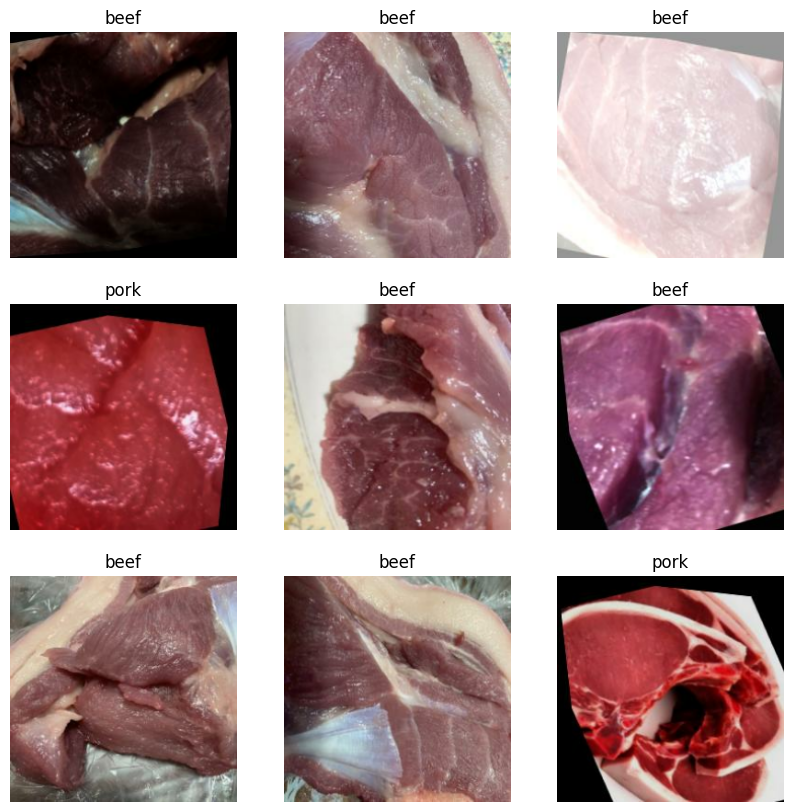

In [ ]:
#show train images samples

class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#Optimising input pipeline performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
valid_dataset = valid_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# preprocess input images before feeding them into the MobileNetV2 mode
prep_input = tf.keras.applications.mobilenet_v2.preprocess_input
# rescale the image values
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
image_shape = image_size + (3,) #represents the number of color channels (RGB) in the image.

#create base model using MobileNetV2, activation softmax
base_model = tf.keras.applications.MobileNetV2(input_shape=image_shape,
                                               include_top=False,
                                               weights='imagenet',
                                               classes=2,
                                               classifier_activation="softmax")

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [ ]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
#add
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
from keras.layers import BatchNormalization
from keras import Model

inputs = base_model.input
#inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu', name='new_layer_1')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu', name = 'new_layer_2')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu', name = 'new_layer_3')(x)

prediction_layer = Dense(2, activation='softmax', name = 'predictions')(x)

outputs = prediction_layer
model = tf.keras.Model(inputs, outputs)

In [ ]:
#Compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [ ]:
#Evaluate the model
initial_epochs = 10
loss0, accuracy0 = model.evaluate(valid_dataset)

9/9 [==============================] - 3s 93ms/step - loss: 2.1580 - accuracy: 0.5431


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.16
initial accuracy: 0.54


In [ ]:
#Train the model
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=valid_dataset)

Epoch 1/10
77/77 [==============================] - 10s 59ms/step - loss: 0.7070 - accuracy: 0.6976 - val_loss: 0.7411 - val_accuracy: 0.7640
Epoch 2/10
77/77 [==============================] - 5s 63ms/step - loss: 0.3730 - accuracy: 0.8276 - val_loss: 0.2707 - val_accuracy: 0.9026
Epoch 3/10
77/77 [==============================] - 6s 67ms/step - loss: 0.2731 - accuracy: 0.8902 - val_loss: 0.2418 - val_accuracy: 0.9026
Epoch 4/10
77/77 [==============================] - 4s 52ms/step - loss: 0.1974 - accuracy: 0.9268 - val_loss: 0.1703 - val_accuracy: 0.9288
Epoch 5/10
77/77 [==============================] - 5s 69ms/step - loss: 0.1527 - accuracy: 0.9524 - val_loss: 0.1685 - val_accuracy: 0.9326
Epoch 6/10
77/77 [==============================] - 4s 54ms/step - loss: 0.1202 - accuracy: 0.9598 - val_loss: 0.1667 - val_accuracy: 0.9363
Epoch 7/10
77/77 [==============================] - 5s 59ms/step - loss: 0.0864 - accuracy: 0.9797 - val_loss: 0.1715 - val_accuracy: 0.9288
Epoch 8/10
7

In [ ]:
#model_path = '/content/drive/MyDrive/befork.h5'
model.save('befork.h5')

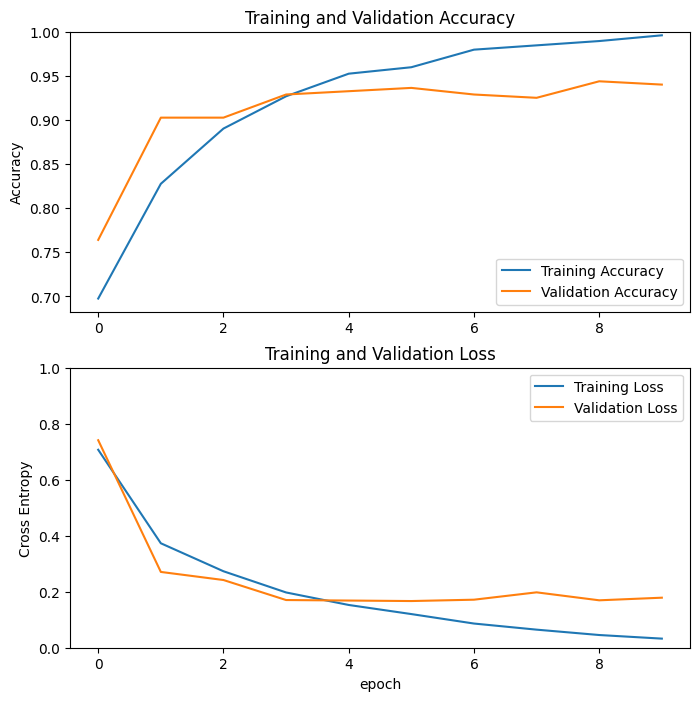

In [ ]:
#plot the training result
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Add Fine Tuning For Model

In [ ]:
base_model.trainable = True

ft_at = 80
#freeze the layers before 100 layer
for layer in base_model.layers[:-1]:
  layer.trainable = False

In [ ]:
# compile the model
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [ ]:
#Re train model after use fine tune
new_epochs = 10
total =  initial_epochs + new_epochs
hist_fine = model.fit(train_dataset,
                         epochs=total,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_dataset)

Epoch 10/20
77/77 [==============================] - 10s 63ms/step - loss: 0.0211 - accuracy: 0.9988 - val_loss: 0.1591 - val_accuracy: 0.9401
Epoch 11/20
77/77 [==============================] - 4s 52ms/step - loss: 0.0227 - accuracy: 0.9967 - val_loss: 0.1719 - val_accuracy: 0.9401
Epoch 12/20
77/77 [==============================] - 6s 67ms/step - loss: 0.0177 - accuracy: 0.9976 - val_loss: 0.1673 - val_accuracy: 0.9438
Epoch 13/20
77/77 [==============================] - 5s 62ms/step - loss: 0.0142 - accuracy: 0.9992 - val_loss: 0.1837 - val_accuracy: 0.9363
Epoch 14/20
77/77 [==============================] - 5s 58ms/step - loss: 0.0126 - accuracy: 0.9996 - val_loss: 0.1917 - val_accuracy: 0.9363
Epoch 15/20
77/77 [==============================] - 4s 53ms/step - loss: 0.0158 - accuracy: 0.9984 - val_loss: 0.1759 - val_accuracy: 0.9363
Epoch 16/20
77/77 [==============================] - 5s 64ms/step - loss: 0.0139 - accuracy: 0.9988 - val_loss: 0.2135 - val_accuracy: 0.9251
Epoch

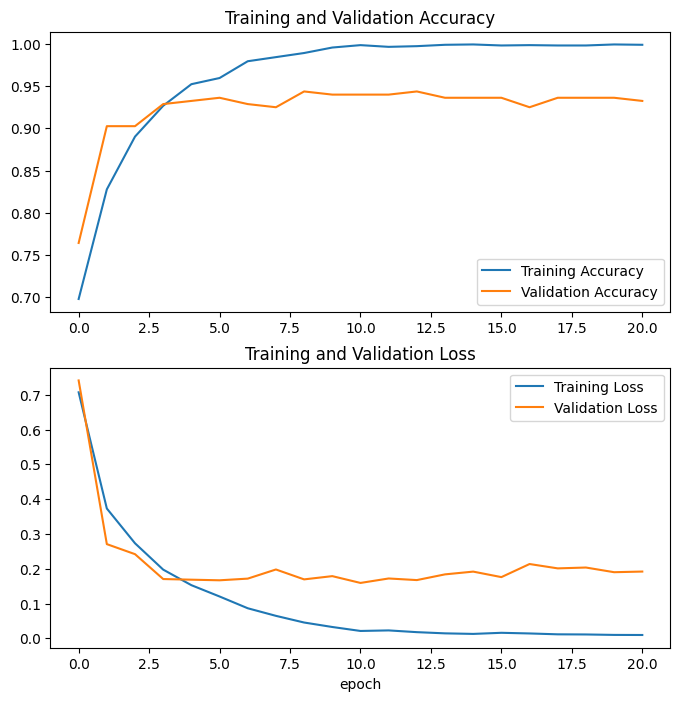

In [ ]:
#Let see training result plot after add finetunning
acc += hist_fine.history['accuracy']
val_acc += hist_fine.history['val_accuracy']

loss += hist_fine.history['loss']
val_loss += hist_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#evaluate the model after finetunning
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

4/4 [==============================] - 1s 215ms/step - loss: 0.2068 - accuracy: 0.9407
Test accuracy : 0.9406779408454895


In [ ]:
y_preds = []
y_true = []

for image_batch, label_batch in test_dataset:
    y_true.append(label_batch)
    pred = model.predict(image_batch)
    y_preds.append(np.argmax(pred, axis = -1))
    
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_preds], axis = 0)

1/1 [==============================] - 1s 877ms/step


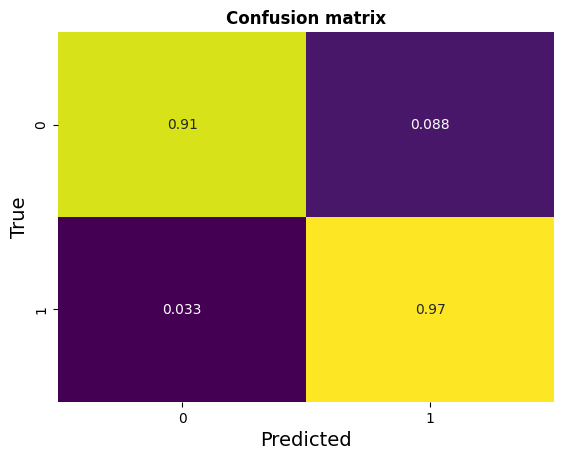

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(correct_labels, predicted_labels, normalize='true')
sns.heatmap(cm, annot=True, cmap='viridis', cbar=None)
plt.title("Confusion matrix", fontweight='bold')
plt.ylabel("True", fontsize=14)
plt.xlabel("Predicted", fontsize=14)
plt.show()

Predicted Labels:
 [0 1 1 1 1 0 1 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 0 0 1 0 0 0 1 0 1 1]
Probabilities:
 [0.7274591  0.72340983 0.73083526 0.60173    0.7294683  0.7304927
 0.7296074  0.7309982  0.70192313 0.7310423  0.7310536  0.7294061
 0.73105496 0.7303486  0.7216138  0.73082983 0.73079646 0.73096913
 0.7301347  0.7305902  0.5751188  0.6122878  0.7310567  0.73002845
 0.7263941  0.7282832  0.7310532  0.6775204  0.72806734 0.73104
 0.6203589  0.72780436]
True Labels:
 [0 1 1 1 1 0 1 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1 0 0 1 0 0 0 1 0 1 1]


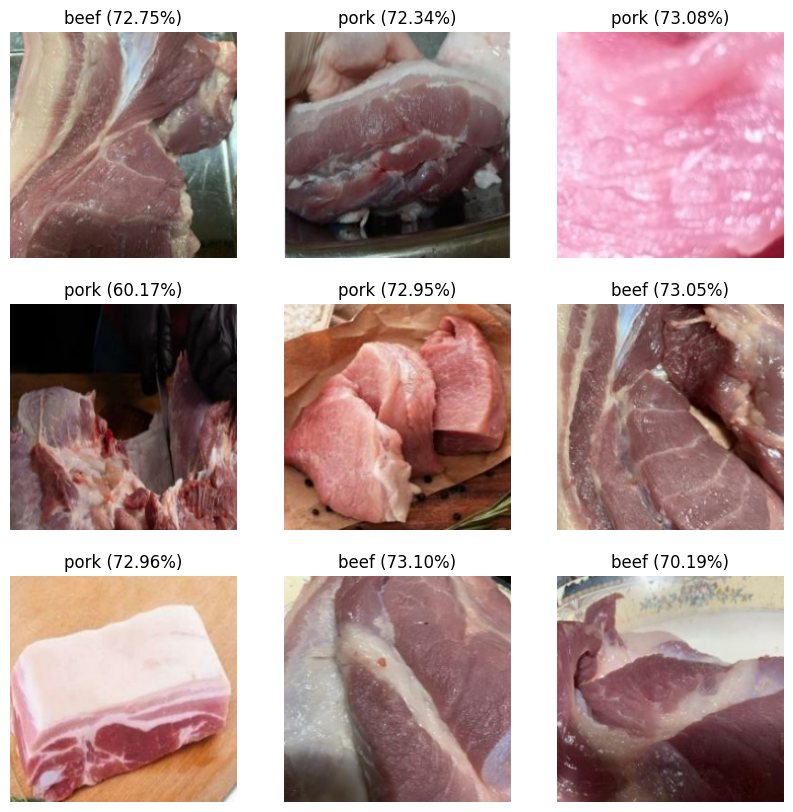

In [ ]:
#Let test final model
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Apply softmax activation
predictions = tf.nn.softmax(predictions)

# Get the predicted class labels
predicted_labels = tf.argmax(predictions, axis=1)

# Get the probabilities for the predicted classes
probabilities = tf.reduce_max(predictions, axis=1)

print('Predicted Labels:\n', predicted_labels.numpy())
print('Probabilities:\n', probabilities.numpy())
print('True Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title("{} ({:.2f}%)".format(class_names[predicted_labels[i]], probabilities[i] * 100))
    plt.axis("off")


In [ ]:
model.save('lastmodelbefork.h5')

In [ ]:
#Let Test using exported model HDF5
import tensorflow as tf
from PIL import Image
import numpy as np

def classify(model, image_path):
    image = Image.open(image_path)
    image = image.resize((224, 224))
    #image = np.array(image) / 255.0  # Normalize image

    image = np.expand_dims(image, axis=0)

    predictions = model.predict(image)
    predicted_label = np.argmax(predictions, axis=1)[0]
    probabilities = tf.reduce_max(predictions, axis=1)

    class_names = ['beef', 'pork']  
    predicted_class = class_names[predicted_label]

    print('Predicted Class:', predicted_class)
    print('Probabilities:\n', probabilities.numpy())

# Assuming you have already loaded and compiled your TensorFlow model
model = tf.keras.models.load_model('/content/lastmodelbefork.h5')

# Example usage
#image_path = '/content/test/pork/13958025-sliced-raw-meat-isolated-on-white_jpg.rf.4a0f5c178259b996605b14111c233835.jpg' #pork
#image_path = '/content/drive/MyDrive/Pork_NonPork/test/pork/Screenshot_458.jpg' #pork
#image_path = "/content/drive/MyDrive/Pork_NonPork/test/pork/Screenshot_521.jpg" #pork
image_path = "/content/test/beef/FRESH-10-_JPG_jpg.rf.9b20f06d4a6329ea5f7fb60717d4009b.jpg" #beef
classify(model, image_path)


'''testing = "/content/drive/MyDrive/Pork_NonPork/testing"
for filename in os.listdir(testing):
  label = classify(model, f"{testing}/{filename}")'''

1/1 [==============================] - 1s 773ms/step
Predicted Class: beef
Probabilities:
 [0.9999014]


'testing = "/content/drive/MyDrive/Pork_NonPork/testing"\nfor filename in os.listdir(testing):\n  label = classify(model, f"{testing}/{filename}")'